# Mini Project 1 
## Team 9. Structure 이정은, 문영운, 안혜윤, 구자현, 문종현 
  
    
### 주제: 유튜브 API를 활용하여 채널의 실시간 정보 수집하기
  
프로젝트 개요 :   
좋아하는 유튜버의 채널 규모를 한 번 분석해보고 싶다 ! 
조회수가 많이 나오는 영상 타이틀이 따로 있을까? 라는 궁금증에 해당 주제를 선정하게 되었습니다. 다양한 관점에서 접근하여 채널의 성향과 방향성을 한 번 읽어보고자 하는 것이 우리 프로젝트의 목표입니다 !


주요 분석 과제 :   
- 원하는 채널의 성장 지표 분석  
- 다른 채널들과 시간에 따라 어떻게 변화하는 지 비교
- 조회수가 높은 영상 제목에서 자주 사용되는 단어를 분석
- 가장 인기 있는 영상의 댓글 주요 키워드 시각화   
     
사용한 라이브러리 및 데이터 수집 방법 : 
youtubeAPI, wordcloud, seaborn, pandas , os, matplotlib , tqdm , datetime, googleapiclient , collections, konlpy, platform, IPython.display ... 

# 유튜브 채널의 업로드된 영상 목록 데이터 수집하기 


In [ ]:
# 라이브러리 로드 
import numpy as np
import pandas as pd
import requests
import json
from datetime import datetime as dt
from tqdm import tqdm
import time
import pandas
from googleapiclient.discovery import build
import os
import seaborn as sns 

import warnings # 경고창 무시
warnings.filterwarnings('ignore')

# 1번 원래 내 구글계정 
# 2번 멋사 구글 계정
API_KEY = ["", ""]
DEVELOPER_KEY = API_KEY[0]
YOUTUBE_API_SERVICE_NAME = "youtube"
YOUTUBE_API_VERSION = "v3"

youtube = build(YOUTUBE_API_SERVICE_NAME, YOUTUBE_API_VERSION,developerKey=DEVELOPER_KEY)


In [ ]:
# 데이터 저장 
def save_file(name, type_ ,df):
    today = dt.today().strftime("%Y%m%d")
    file_name = f'Youtube_{type_}_{name}_{today}'
    version = 0 
    while os.path.isfile(f'./{file_name}_v{version}.csv'):
        version += 1 
    df.to_csv(f'./{file_name}_v{version}.csv', index=False)


# SEARCH API 
def get_channel(channel_name, api_key):
    global youtube
    # 구글 Search API를 사용해서 입력한 채널의 정보를 가져온다. 
    # search_response dictionary 객체를 반환한다. 

    search_response = youtube.search().list(
        q = channel_name,
        order = "relevance",
        part = "snippet",
        maxResults = 50
    ).execute()

    channel_Id = search_response['items'][0]['id']['channelId']
    # search_response dictionary 객체를 반환한다. 
    return channel_Id 



def scroll(channel_Id):
    video_list = []
    # 스크롤이 되지 않을 때까지 nextpageToken 무한 호출  
    try : 
        res = youtube.channels().list(id=channel_Id, part='contentDetails').execute()
        # 플레이리스트 가져오기 
        playlist_id = res['items'][0]['contentDetails']['relatedPlaylists']['uploads']

        next_page = None
        while len(video_list) < 1000:
            # print(len(video_list))

            res = youtube.playlistItems().list(playlistId=playlist_id,part='snippet',maxResults=50,pageToken=next_page).execute() 
            video_list += res['items']
            next_page = res.get('nextPageToken')

            if next_page is None :
                break
            
        return video_list
    except Exception as e:
        print('API 호출 한도 초과')
        return video_list


def get_video_id(channel_name, api_key):
    global youtube    
    channel_Id = get_channel(channel_name, api_key)
    video_list = scroll(channel_Id)
    # 추출한 데이터를 저장하는 dataframe 객체 생성  
    df_video = pd.DataFrame() 
    for item in video_list:
        item_dict = {}
        #  채널, 재생목록, 비디오 영상 정보들이 다 섞여있어서 videoId 가 있는 
        # items에 접근하여 데이터를 가져옴 
        # 제목과 video_key 반환 
        item_dict['title'] = item['snippet']['title']
        item_dict['video_id'] = item['snippet']['resourceId']['videoId']
        df_video = df_video.append(item_dict , ignore_index = True)
    
    # df 객체 반환 
    return df_video


def get_channel_info(channel_name, api_key , name):
    global youtube
    
    df_video_info = pd.DataFrame()
    df_url =  get_video_id(channel, api_key)
    url_list = df_url['video_id'].to_list()

    try :
        for video_id in url_list:
            item_list = {} 
            res = youtube.videos().list(id = video_id, part='snippet,contentDetails,statistics').execute()
            if res['items']:
                item_list['video_id'] = video_id 
                item_list['title'] = res['items'][0]['snippet']['title']
                # 'publishedAt': '2022-09-30T15:05:02Z'
                item_list['date'] = res['items'][0]['snippet']['publishedAt'].split('T')[0]
                # 통계지표 가져오기
                # NaN값은 0으로 간주
                item_list['view'] = int(res['items'][0]['statistics']['viewCount']) if 'viewCount' in res['items'][0]['statistics'] else 0
                item_list['likecnt'] = int(res['items'][0]['statistics']['likeCount']) if 'likeCount' in res['items'][0]['statistics'] else 0  
                item_list['comment'] = int(res['items'][0]['statistics']['commentCount']) if 'commentCount' in res['items'][0]['statistics'] else 0
                df_video_info = df_video_info.append(item_list, ignore_index = True).reset_index(drop=True)
        
        # save data 
        df_video_info['channel_name'] = channel_name
        save_file('video', name, df_video_info)
        return df_video_info
        
    except Exception as e:
        print('DataFrame 생성 에러')
        return df_video_info


## 채널 별 가장 인기있는 영상 TOP10

In [3]:
channel = '동빈나'

# 파일로 저장할 때 쓰일 채널네임
name = "동빈나"
df_channel_info = get_channel_info(channel, API_KEY, name)
df_channel_info

,video_id,title,date,view,likecnt,comment,channel_name
0,hoWQWbMFodc,"AI 분야 취업을 위한 ""무료"" 교육과정(부트캠프)을 소개합니다!",2022-08-06,13142.0,181.0,28.0,동빈나
1,n_FDGMr4MxE,[꼼꼼한 논문 설명] U-Net: Convolutional Networks for ...,2022-07-23,6557.0,147.0,22.0,동빈나
2,pBoClHDFamE,[꼼꼼한 논문 설명] Toonify (사람 얼굴을 만화 캐릭터 얼굴로 바꾸기): R...,2022-07-16,5126.0,86.0,11.0,동빈나
3,YU_NO7pYObM,[꼼꼼한 논문 설명] Learning Loss for Active Learning ...,2022-07-09,4649.0,86.0,11.0,동빈나
4,cBVTFYVGE2M,[딥러닝 초보자 필수 시청] 딥러닝 공부 순서 한 번에 총 정리,2022-06-04,30301.0,1082.0,86.0,동빈나
...,...,...,...,...,...,...,...
795,j4KIKQFSRNc,버블 정렬 알고리즘(Bubble Sort Algorithm),2016-11-28,4290.0,24.0,5.0,동빈나
796,cuyArmvvh0o,선택 정렬 알고리즘(Selection Sort Algorithm),2016-11-28,7371.0,45.0,10.0,동빈나
797,fkWle8N85Jk,아두이노 작품 - 자바 리듬 게임(Arduino Java Rhythm Game),2016-10-28,12183.0,33.0,7.0,동빈나
798,5Hn7VvVILZ4,자바(JAVA) GUI 코인 먹기 게임,2016-07-11,7125.0,19.0,11.0,동빈나


# 특정 영상 하나에 달린 댓글들을 수집

In [ ]:
# !pip install konlpy

In [6]:
# 라이브러리 설치
from wordcloud import WordCloud     # 워드클라우드 호출
import matplotlib.pyplot as plt     # 워드클라우드 시각화
from collections import Counter     # 텍스트 및 빈도수 추출
from konlpy.tag import Okt          # 한국어 형태소 분석 패키지
from PIL import Image               # 워드클라우드 원하는대로 그리기
import pandas as pd
import numpy as np

In [ ]:
def get_comments(video_id, video_name ,API_key):
    global youtube
    comments = []
    cnt = 0

    comment_list_response = youtube.commentThreads().list(
        videoId = video_id,
        order = 'relevance',
        part = 'snippet,replies',
        maxResults = 100
    ).execute()

    while comment_list_response:
        for item in comment_list_response['items']:
            comment = item['snippet']['topLevelComment']['snippet']
            comments.append([comment['textDisplay'], comment['authorDisplayName'], comment['publishedAt'], comment['likeCount']])
            

        if item['snippet']['totalReplyCount']  > 0:
            for reply_item in item['replies']['comments']:
                reply = reply_item['snippet']
                comments.append([reply['textDisplay'], reply['authorDisplayName'], reply['publishedAt'], reply['likeCount']])


        if 'nextPageToken' in comment_list_response:
            comment_list_response = youtube.commentThreads().list(
                videoId = video_id,
                order = 'relevance',
                part = 'snippet,replies',
                pageToken = comment_list_response['nextPageToken'],
                maxResults = 100
            ).execute()
            cnt += 1

        else:
            break

    comment_df = pd.DataFrame(comments, columns = ["comment", "author", "datetime", "like_count"]).dropna()
    print(f"총 {cnt} page의 댓글을 수집했습니다.")
    print(f"총 {len(comment_df)}개의 댓글을 수집했습니다.")
    
    save_file(video_name, "comment" ,comment_df)
    return comment_df

# 유튜브 채널 데이터 시각화 
- make_WordCloud 

In [ ]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq   

In [89]:
def make_WordCloud(df, column_name):
    texts = []
    words = []
    nouns_words_list = []
    okt = Okt()

    for i in range(len(df)):
        texts.append(df[column_name][i])

    for text in texts:
        words = okt.nouns(text) # 명사만 추출
        nouns_words = [n for n in words if len(n) > 1] # 단어의 길이가 1개인 것은 제외

        for nouns_word in nouns_words: 
            nouns_words_list.append(nouns_word)

    c = Counter(nouns_words_list)
    font = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf' #한글 폰트 반환
    wc = WordCloud(font_path = font, width=1000, height=600, scale=2.0, max_font_size=300)
    gen = wc.generate_from_frequencies(c)
    plt.figure(figsize=(20,20)) # 사이즈 조절
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

## 동빈나 채널 데이터 시각화 
- 채널 영상 데이터 기술 통계

In [144]:
# 파일 불러오기 
df = pd.read_csv('Youtube_동빈나_video_20221003_v0.csv', dtype={"itemcode":"object"})
df = df.sort_values(by=["view","likecnt","comment"], ignore_index=True, ascending = False)
video_id = df.sort_values(by=['comment'],ascending = False)['video_id'][0]
video_id

'dh4hdtZ00EU'

In [146]:
df[df['view'] > df['view'].mean()].head()

,video_id,title,date,view,likecnt,comment,channel_name
0,dh4hdtZ00EU,C언어 기초 프로그래밍 강좌 1강 - Hello World (C Programmin...,2017-03-05,677133.0,5545.0,790.0,동빈나
1,ukkLCl9yBvE,대기업 IT직군 코딩테스트 합격을 위한 현실적이고 직관적인 공부 순서,2019-05-26,425752.0,14586.0,612.0,동빈나
2,OZu_BRDqJEQ,알고리즘 실력 유형별 공감 (입문자~썩은물),2021-08-30,378037.0,5489.0,436.0,동빈나
3,wjLwmWyItWI,자바 기초 프로그래밍 강좌 1강 - Hello World! (Java Program...,2017-03-18,344239.0,2199.0,265.0,동빈나
4,V7TXlm7kpaE,C언어 기초 프로그래밍 강좌 2강 - 변수와 상수(Variables & Consta...,2017-03-05,270468.0,1745.0,393.0,동빈나


In [103]:
df.describe()

,view,likecnt,comment
count,800.000000,800.000000,800.000000
mean,22399.863750,203.595000,28.785000
std,43555.041664,664.026947,57.079847
min,789.000000,4.000000,0.000000
25%,5477.250000,36.000000,6.000000
50%,10441.000000,79.000000,13.000000
75%,23902.250000,177.250000,27.000000
max,677133.000000,14586.000000,790.000000


### 동빈나 유튜브 채널의 연도별 조회수, 좋아요 수, 댓글 수 변화

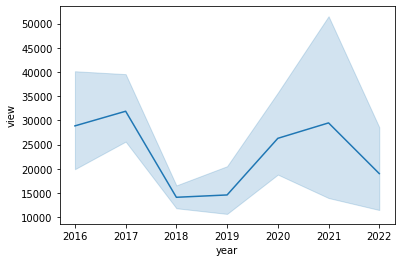

In [127]:
df['date'] =  pd.to_datetime(df["date"])
df['year'] = df['date'].dt.year
sns.lineplot(data=df, x="year", y="view")

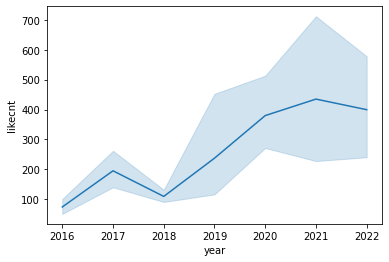

In [128]:
sns.lineplot(data=df, x="year", y="likecnt")

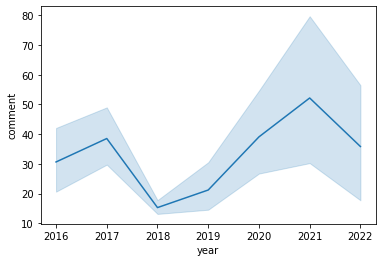

In [129]:
sns.lineplot(data=df, x="year", y="comment")

### 워드클라우드 시각화
- 댓글, 타이틀 주요 키워드 분석 

In [116]:
# video_id
video_name = df.sort_values(by=['comment'],ascending = False)['title'][0]
df_comment = get_comments(video_id, video_name ,API_KEY)
df_comment

총 4 page의 댓글을 수집했습니다.
총 487개의 댓글을 수집했습니다.


,comment,author,datetime,like_count
0,자세한 설명 진심으로 감사드립니다 학교 수업에서는 정말 대충 나가면서 저런 세세한 ...,moraeng,2022-03-13T12:09:01Z,3
1,"안녕하세요 동빈선생님 ,<br>배우기전엔 좀 두려웠는데, 덕분에 어렵지않게 시작하고...",아니왜맨날ㅅㅂISTJ이래,2022-08-21T12:19:49Z,0
2,동빈나님 제가봤던 c언어 기초강좌중에 제일 이해가잘가고 세심한것까지 알려주시는 분은...,김태욱,2019-01-20T13:45:16Z,6
3,안녕하세요~-!게임을 좋아해서 현재는 게임 그래픽 쪽을 공부하고 있는데 프로그래밍에...,LU NE,2018-10-04T18:54:41Z,1
4,게임개발의 관심을 갖는 고1인데 강의가 이해하기 쉽고 배울 것도 많아서 정말 좋아요...,수르아,2018-09-10T15:04:26Z,1
...,...,...,...,...
482,동씨도 있구나..ㅡ.ㅡ;;,phoenixeyes,2019-12-23T08:13:36Z,0
483,와드,장혁,2020-05-19T09:13:36Z,0
484,first,Sam Alberico,2017-03-05T02:02:48Z,0
485,2021 . 3 . 7,72 gn,2021-03-07T12:27:10Z,0


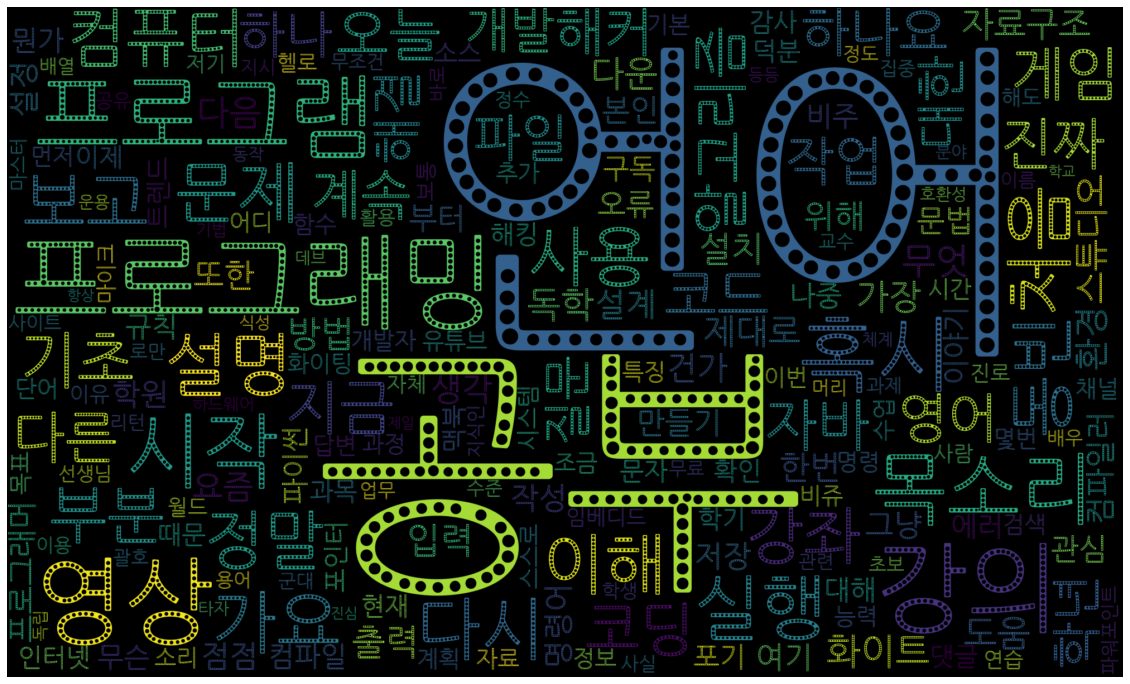

In [117]:
# df_comment = get_comments(video_id, video_name ,API_KEY)
make_WordCloud(df_comment,'comment')

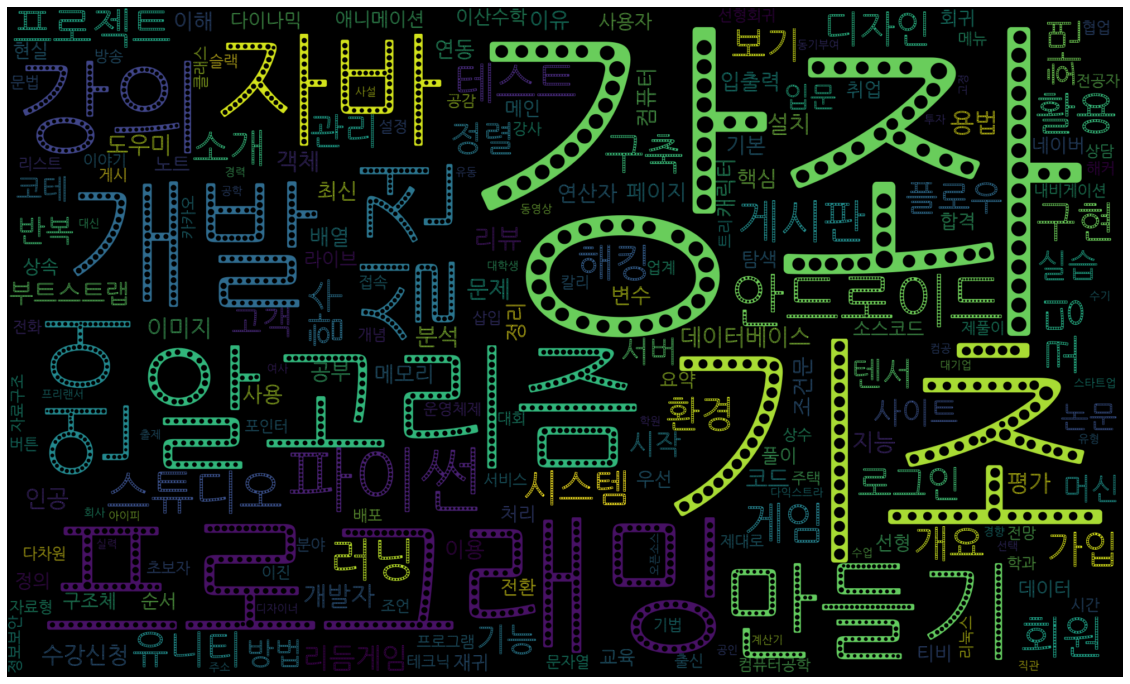

In [108]:
make_WordCloud(df[df['view'] > 20000],'title')

# 유명 IT유튜브 채널들 데이터 비교하기 

In [ ]:
# Linux(colab)
# !apt-get install fonts-nanum -qq  > /dev/null
# !fc-cache -fv

In [147]:
import platform
import matplotlib as mpl
# 레티나 디스플레이로 폰트가 선명하게 표시되도록 함
from IPython.display import set_matplotlib_formats

# 한글 폰트 설정
def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    system_name = platform.system()

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont
        
        font_family = "NanumBarunGothic"
    return font_family

In [148]:
# 한글폰트를 설정
plt.rc("font", family=get_font_family())
plt.rc("axes", unicode_minus=False)

set_matplotlib_formats("retina")

/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 31 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [132]:
df_no = pd.read_csv("./Youtube_scrap_노마드코더_2022-10-03_v0.csv")
df_dong = pd.read_csv("./Youtube_scrap_동빈나_2022-10-03_v0.csv")
df_saeng = pd.read_csv("./Youtube_scrap_생활코딩_2022-10-03_v0.csv")
df_jo = pd.read_csv("./Youtube_scrap_조코딩_2022-10-03_v0.csv")

In [134]:
df_all = pd.concat([df_no, df_dong, df_saeng, df_jo])

In [136]:
# type을 object에서 datetime으로 변경
df_all["date"] = pd.to_datetime(df_all["date"])

# 연도 파생변수 추출
df_all["year"] = df_all["date"].dt.year
df_all.shape

(2349, 8)

중복된 데이터 없음 

In [157]:
df_all[df.duplicated()]

,video_id,title,date,view,likecnt,comment,channel_name,year


In [138]:
df_all_group = df_all.groupby(["year", "channel_name"]).sum()
df_all_group

view   likecnt  comment
year channel_name                                      
2017 노마드 코더 Nomad Coders    685150.0    5573.0    741.0
     동빈나                   7861516.0   48135.0   9513.0
2018 노마드 코더 Nomad Coders   3263821.0   37364.0   4638.0
     동빈나                   3042983.0   23639.0   3308.0
2019 노마드 코더 Nomad Coders   8217371.0  221644.0  18090.0
     동빈나                   2520860.0   41036.0   3672.0
     생활코딩                  4995675.0   45390.0   5925.0
     조코딩 JoCoding          5550764.0  128626.0  13927.0
2020 노마드 코더 Nomad Coders   5785984.0  144290.0  16245.0
     동빈나                   1523517.0   22016.0   2267.0
     생활코딩                  2510282.0   36479.0   5438.0
     조코딩 JoCoding          6228884.0  112655.0  19792.0
2021 노마드 코더 Nomad Coders   8266325.0  254981.0  18883.0
     동빈나                   1296060.0   19129.0   2295.0
     생활코딩                  1109638.0   16431.0   2369.0
     조코딩 JoCoding         26452617.0  445394.0  39259.0
2022 노마드 코더 Nomad Coders   3879672.0  115143.0   7554.0
     동빈나                    246643.0    5192.0    466.0
     생활코딩                   644135.0   10794.0   1171.0
     조코딩 JoCoding         22331745.0  279694.0  19632.0

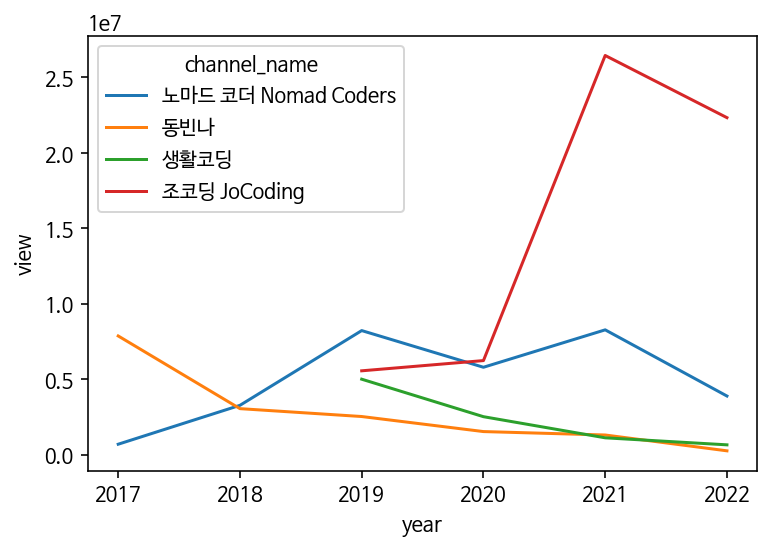

In [149]:
sns.lineplot(data=df_all_group, x="year", y="view", hue="channel_name")

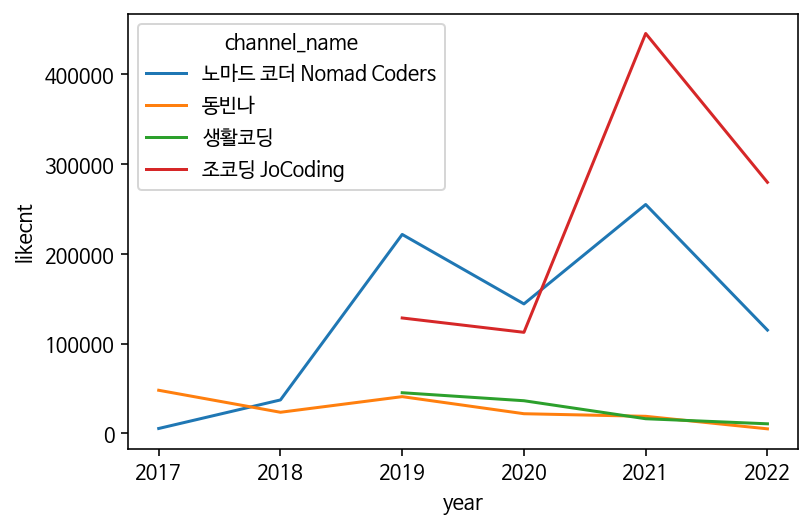

In [150]:
sns.lineplot(data=df_all_group, x="year", y="likecnt", hue="channel_name")

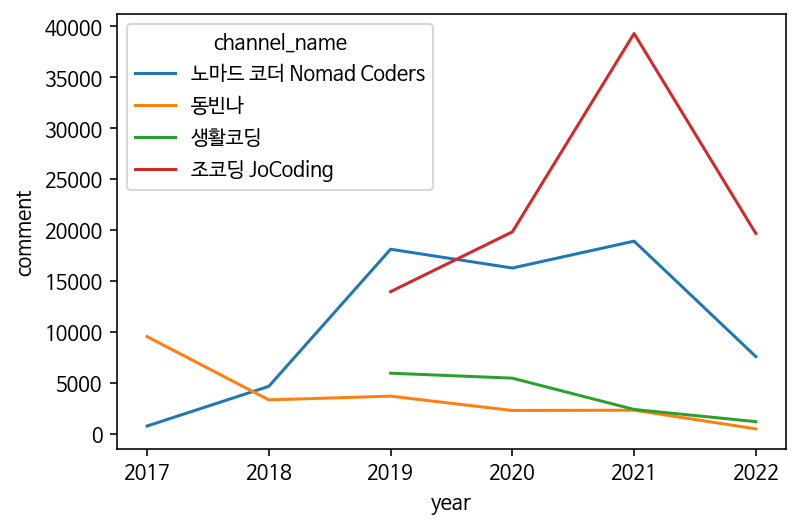

In [151]:
sns.lineplot(data=df_all_group, x="year", y="comment", hue="channel_name")

## Shorts // 일반 영상 데이터 비교 

In [152]:
# 파일 불러오기 
data_list = ['Youtube_scrap_조코딩_2022-10-03_v0','Youtube_scrap_생활코딩_2022-10-03_v0','Youtube_scrap_동빈나_2022-10-03_v0','Youtube_scrap_노마드코더_2022-10-03_v0']
data = []
for i in data_list:
    data.append(pd.read_csv(f'./{i}.csv', dtype={"itemcode":"object"}, parse_dates=["date"])) ## csv 불러올 때 date 칼럼 datetime형식으로 불러오도록 수정했습니다!
    
df = pd.concat(data).reset_index(drop=True).sort_values(by=["view","likecnt","comment"], ignore_index=True, ascending = False)
video_id = df['video_id'][0]
video_name = df['title'][0]
df.shape


(2349, 7)

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2349 entries, 0 to 2348
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   video_id      2349 non-null   object        
 1   title         2349 non-null   object        
 2   date          2349 non-null   datetime64[ns]
 3   view          2349 non-null   float64       
 4   likecnt       2349 non-null   float64       
 5   comment       2349 non-null   float64       
 6   channel_name  2349 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 128.6+ KB


In [158]:
# 날짜별 분석을 위해 파생변수 생성
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["dayofweek"] = df["date"].dt.dayofweek # 요일

In [159]:
df[df.duplicated()]

,video_id,title,date,view,likecnt,comment,channel_name,year,month,dayofweek


In [160]:
# 쇼츠 / 일반 분할
df_shorts = df[df["title"].str.contains("Shorts")]
df_normal = df[~df["title"].str.contains("Shorts")]
print(df_normal.shape)
print(df_shorts.shape)

(2290, 10)
(59, 10)


In [163]:
df_normal.head()

,video_id,title,date,view,likecnt,comment,channel_name,year,month,dayofweek
7,EqoU1PodQQ4,"무료 쉬운 게임 개발 강의 - 3시간만에 개발, 출시, 수익화까지 완성",2022-01-23,1644829.0,17049.0,1447.0,조코딩 JoCoding,2022,1,6
9,wpUiN5hBnyc,"코딩 배워서 앱, 웹 만들고 싶으신가요? 코딩 공부 순서 정리해드립니다.",2019-02-27,1519049.0,39950.0,2427.0,조코딩 JoCoding,2019,2,2
10,_ay3CbJkjBg,노트북 배터리 없을때 핵꿀팁 #shorts,2022-07-31,1407838.0,7495.0,602.0,조코딩 JoCoding,2022,7,6
13,zGrTT4k1-yc,C. C++. C#. 차이점 알려드림. 5분 순삭.,2019-10-07,1329517.0,44366.0,2292.0,노마드 코더 Nomad Coders,2019,10,0
17,f53Xk2uuwNY,일반인이 생각하는 프로그래밍 vs 현실 프로그래밍 2탄,2021-02-14,1003993.0,12018.0,2033.0,조코딩 JoCoding,2021,2,6


In [165]:
df_shorts.head()

,video_id,title,date,view,likecnt,comment,channel_name,year,month,dayofweek
0,cXB8rCW7lto,일반인이 생각하는 프로그래밍 vs 현실 프로그래밍 #Shorts,2021-01-10,4018274.0,77805.0,6641.0,조코딩 JoCoding,2021,1,6
1,myZzqZr29tk,개발자 빡치게 하는 방법 #Shorts,2021-04-30,3674635.0,47135.0,2740.0,조코딩 JoCoding,2021,4,4
2,DwwDDUJ4uFk,ㅎㅋ처럼 보이는 3가지 방법 #Shorts,2021-01-24,3401655.0,96163.0,2650.0,조코딩 JoCoding,2021,1,6
3,lj1qmbYlIhw,회사에서 바빠보이는 방법 #Shorts,2022-07-03,2018341.0,59645.0,526.0,조코딩 JoCoding,2022,7,6
4,6yNzMI1G8DE,아이폰으로 갤럭시 쓰는 방법 #Shorts,2021-05-26,1960840.0,21685.0,1406.0,조코딩 JoCoding,2021,5,2


In [166]:
# 과학적 표기법 해제
pd.set_option('display.float_format', '{:.1f}'.format)

In [167]:
df_normal.describe()

,view,likecnt,comment,year,month,dayofweek
count,2290.0,2290.0,2290.0,2290.0,2290.0,2290.0
mean,34714.5,632.5,70.0,2019.1,6.0,2.8
std,96948.7,2088.5,196.0,1.4,3.3,2.1
min,192.0,0.0,0.0,2017.0,1.0,0.0
25%,4658.8,43.0,5.0,2018.0,3.0,1.0
50%,10284.0,106.0,13.0,2019.0,6.0,3.0
75%,26870.5,289.8,39.0,2020.0,9.0,5.0
max,1644829.0,44366.0,2427.0,2022.0,12.0,6.0


In [168]:
df_shorts.describe()

,view,likecnt,comment,year,month,dayofweek
count,59.0,59.0,59.0,59.0,59.0,59.0
mean,625719.9,9578.6,592.4,2021.5,7.4,3.8
std,902762.5,18264.2,1255.3,0.5,2.9,1.9
min,5702.0,65.0,6.0,2021.0,1.0,0.0
25%,86798.0,1274.0,90.5,2021.0,6.0,3.0
50%,207365.0,2899.0,179.0,2021.0,9.0,4.0
75%,787040.0,7792.5,408.0,2022.0,9.0,6.0
max,4018274.0,96163.0,6641.0,2022.0,12.0,6.0


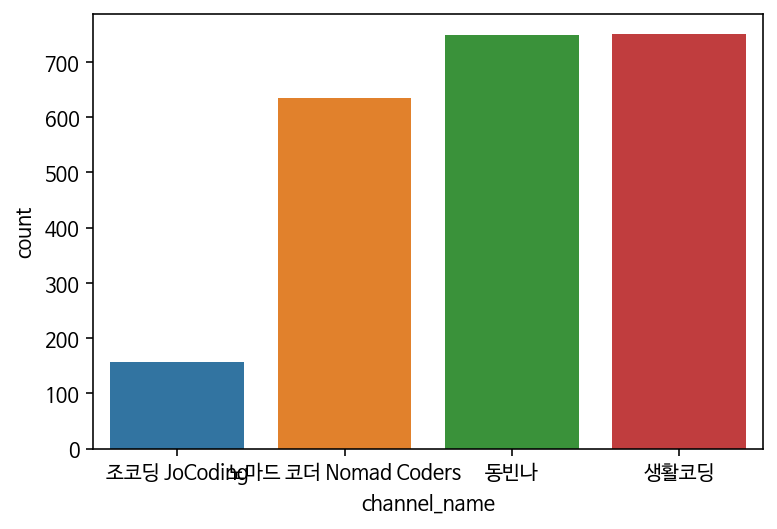

In [172]:
# 채널 별 일반 영상 수
sns.countplot(data = df_normal, x="channel_name")

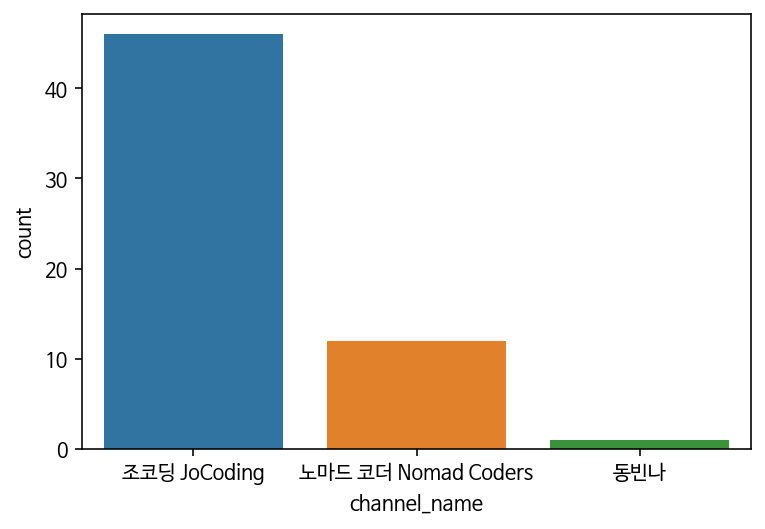

In [173]:
# 채널 별 쇼츠 영상 수
sns.countplot(data = df_shorts, x="channel_name")

[Text(0.5, 1.0, '월별 조회수(쇼츠)')]

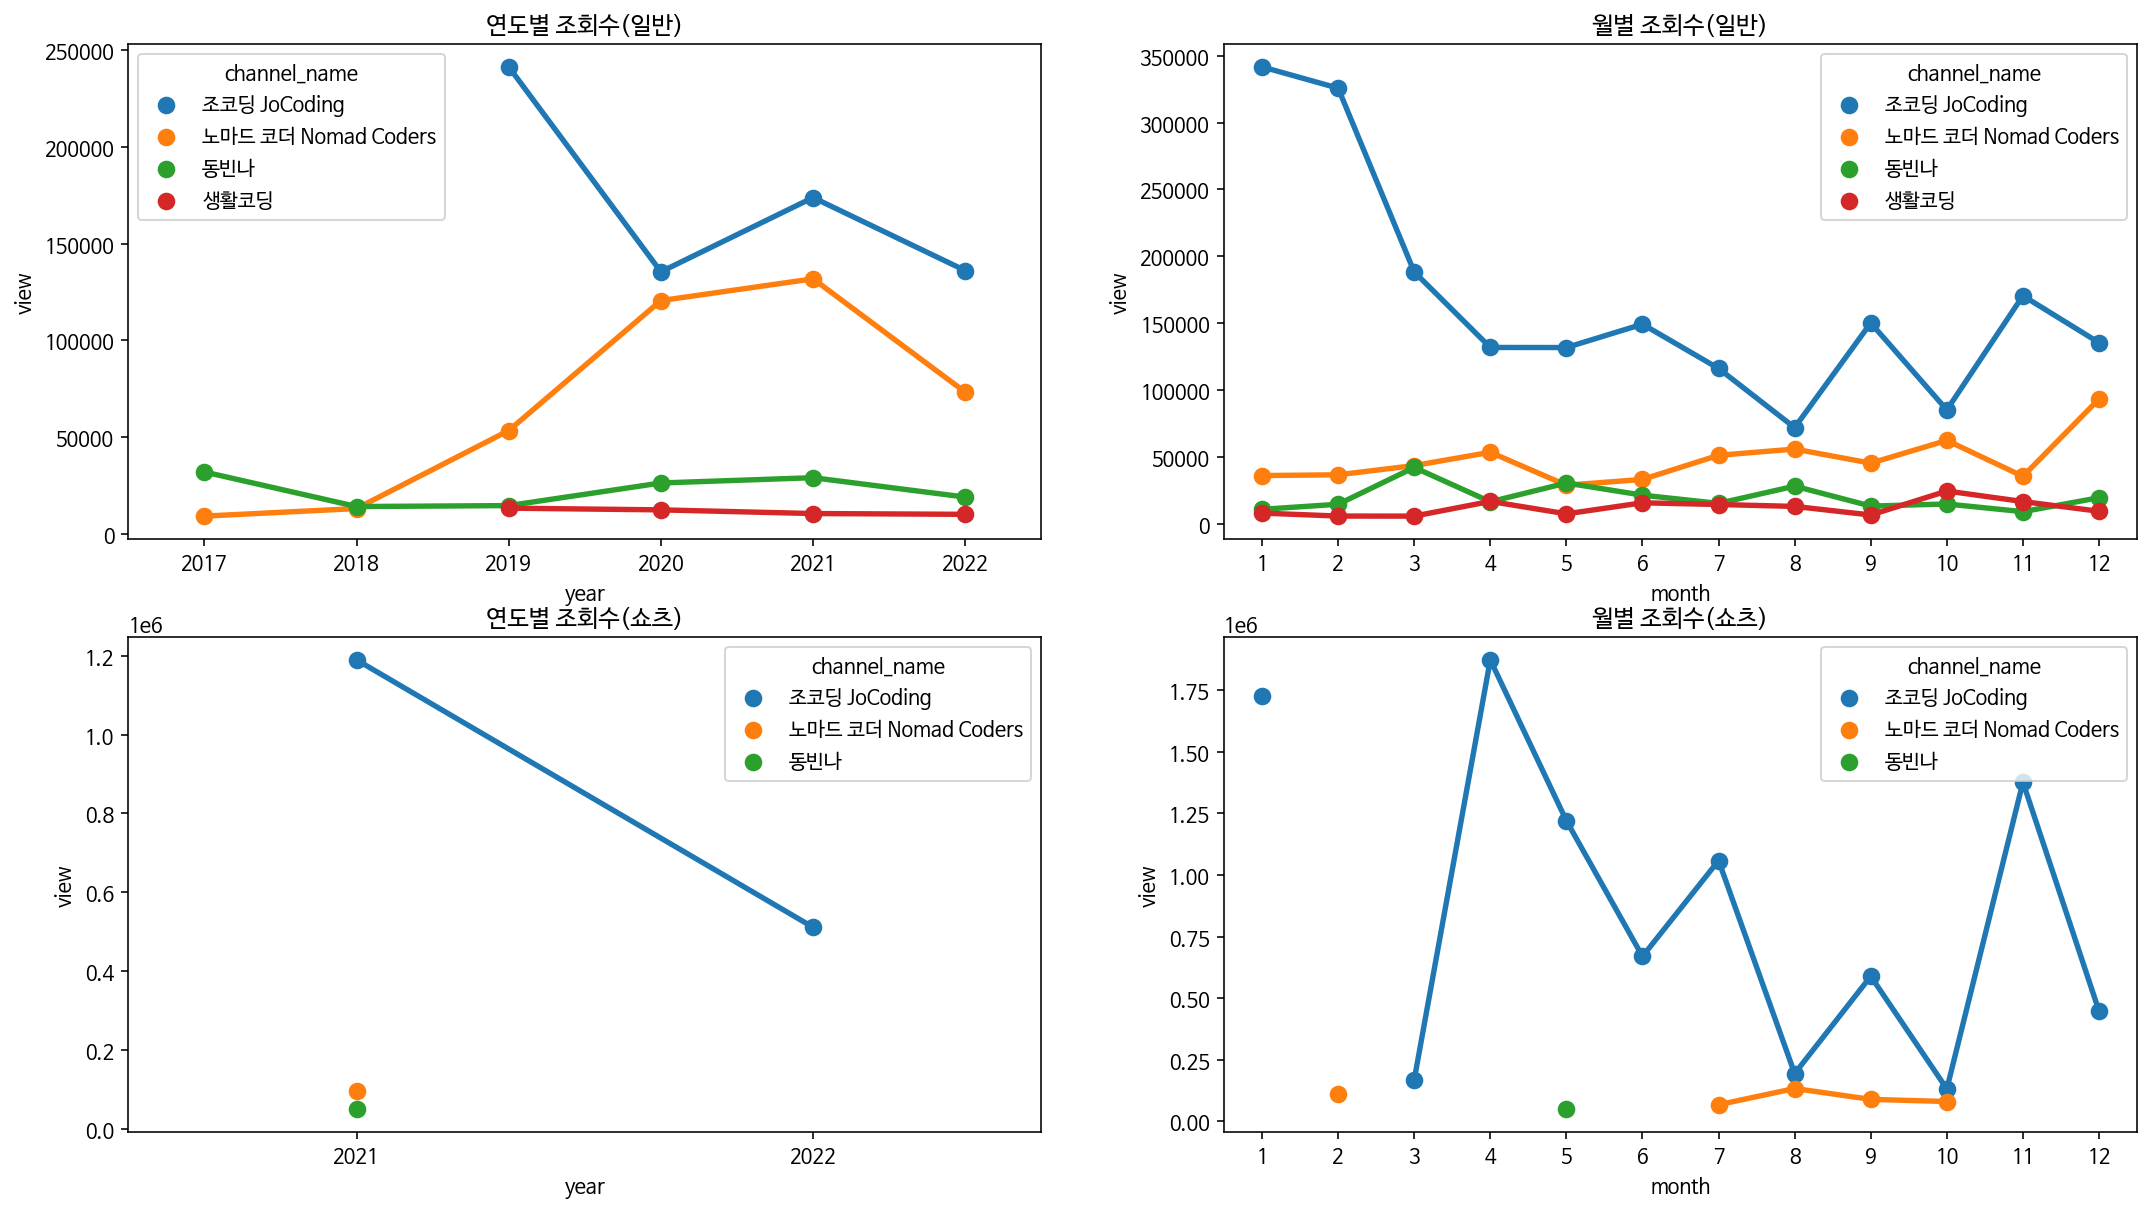

In [174]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(18,10)

sns.pointplot(data=df_normal, x="year", y="view", hue="channel_name", ax=axes[0][0], ci=None)
sns.pointplot(data=df_normal, x="month", y="view", hue="channel_name", ax=axes[0][1], ci = None)
sns.pointplot(data=df_shorts, x="year", y="view", hue="channel_name", ax=axes[1][0], ci = None)
sns.pointplot(data=df_shorts, x="month", y="view", hue="channel_name", ax=axes[1][1], ci = None)

axes[0][0].set(title = '연도별 조회수(일반)')
axes[0][1].set(title = '월별 조회수(일반)')
axes[1][0].set(title = '연도별 조회수(쇼츠)')
axes[1][1].set(title = '월별 조회수(쇼츠)')